In [1]:
%matplotlib inline

30.07.2016, Pawel [alxd](https://alxd.org/) Chojnacki
# NeuroOn Hypnogram Analysis

Following my principles of Open Access and Open Notebook Science I'd like to present you my comparative analysis of NeuroOn and a professional polisomnograph recording from two nights. To learn more about the experiment itself, please head back to my [previous blog post](https://alxd.org/neuroon-analysis-sources.html).

*[more on NeuroOn and AURA PSG, make assumption that Aura is the closest thing to what is actually happening in the brain]*

At the moment of writing this I haven't been professionally involved in EEG analysis for over two years - please feel free to comment on my code and let me know if any part is unclear or may lead to wrong conclusions.

## Signal formats

NeuroOn signal was obtained by using proprietary Intelclinic's scripts I am not allowed to share. They produced four CSV files, containing respectively:

 - EEG signal (125 Hz)
 - accelerometer signal
 - LED activity
 - Staging ([hypnogram](https://en.wikipedia.org/wiki/Hypnogram))

AURA PSG signal was exported to an EDF format using Grass Technologies PSG TWin 4.5.4 and 4.5.2 to minimize the risk of software-derived artifacts. The channels signals include:

 - EOG1-A1
 - EOG2-A1
 - CHIN1-CHIN2
 - CHIN2-CHIN3
 - F3-A2
 - C3-A2
 - O1-A2
 - F4-A1
 - C4-A1
 - O2-A1
 - SNORE (first night only)
 - FLOW (first night only)
 - CHEST (first night only)
 - ABDOMEN (first night only)
 - ECG (first night only)
 - SaO2 (blood oxygen saturation, first night only)
 - HR (heart rate, first night only)
 - LEG1 (first night only)
 - LEG2 (first night only)
 - Pos (first night only)

PSG signals from both nights were scored by a professional and exported to XLS and CSV files.

Since proper comparative analysis of NeuroOn's and AURA's signals would require an immense amount of work, I'd like to start with comparing their hypnograms.

## Time synchronisation

Hypnogram comparison requires us to synchronise signals from both devices in time. With NeuroOn operating in debug mode there was no way I know of to place markers, leaving us with no easy way to sync. To counter that, for the first several minutes of PSG recording I repeatedly clenched my jaw and moved my eyebrows to introduce muscle artifacts to both signals, allowing me to synchronise both afterwards.

Luckily, the latest version of software I was given by Intelclinic supports recovering timestamps from the device, which could make the whole undertaking a lot easier. It should be enough to:

 - find the initial timestamps of both signals
 - [tests - autocorrelation, correlation in time]
 - visualize them
 - adjust or remove hypnogram datapoints outside of common recording time

At this point it's important to remember that the devices recorded signal with different sampling rate, `125 Hz` for NeuroOn and `200 Hz` for AURA.

In [3]:
import pyedflib as el

# first, open the AURA signal file from the first night
edf_file = el.EdfReader('night_01/psg_signal.edf')

In [4]:
# now open NeuroOn signal file
import numpy as np

def make_float(string_list):
    return [float(string_list[0]), float(string_list[1])]

def read_csv_to_int_arrays(filepath):
    with open(filepath) as csv_file:
        signal_array = np.array([make_float(line.strip('\n').split(',')) for line in csv_file.readlines()[1:]])
        return signal_array

neuroon_signal = read_csv_to_int_arrays('night_01/neuroon_signal.csv')

In [5]:
from datetime import datetime

# read respective starting timestamps

psg_start = edf_file.getStartdatetime()
psg_start_timestamp = psg_start.timestamp()
print('PSG recording started', psg_start)


neuroon_start_timestamp = neuroon_signal[0][0]/1000
neuroon_start = datetime.fromtimestamp(neuroon_start_timestamp)
print('NeuroOn recording started', neuroon_start)

PSG recording started 2016-06-20 22:29:48
NeuroOn recording started 2016-06-20 22:01:00


Which suggests that if NeuroOn timestamps are right, it started recording about 28 minutes before the PSG - just after being programmed via the debugger. This is not the only possibility however - we should also check if the signal gathered at the same timestamps corresponds to the signal from the closest PSG electrode - `EOG1-A1`.

In [60]:
# Let's begin with finding a NeuroOn timestamp corresponding with the first Aura's timestamp
print('PSG initial timestamp', psg_start_timestamp)

# NeuroOn sampling rate was specified to be 125 Hz, but let's check
miliseconds_between_125_samples = neuroon_signal[125][0] - neuroon_signal[0][0]
print(miliseconds_between_125_samples, 'miliseconds between 125 NeuroOn samples')

NEUROON_SAMPLE_RATE = 125

# TODO: Refactor everything using miliseconds to make sure about the precision level

seconds_between_startdates = psg_start_timestamp - neuroon_start_timestamp
print('We need to adjust the NeuroOn signal', seconds_between_startdates, 'seconds')

neuroon_sync_index = int(NEUROON_SAMPLE_RATE * seconds_between_startdates)
no_shifted_signal = neuroon_signal[neuroon_sync_index:]
print('Synced signal starts at NeuroOns', neuroon_sync_index, 'index')

print('Timestamps are equal', no_shifted_signal[0][0]/1000 == psg_start_timestamp)

PSG initial timestamp 1466454588.0
1000.0 miliseconds between 125 NeuroOn samples
We need to adjust the NeuroOn signal 1728.0 seconds
Synced signal starts at NeuroOns 216000 index
Timestamps are equal True


Now we can visualize first 10 seconds of each signal to get a visual overview - and run some tests to check if the signals correlate.

http://matplotlib.org/examples/pylab_examples/mri_with_eeg.html
https://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/MultilinePlots.html

In [7]:
# let's get EOG1-A1 signal

print(edf_file.getLabel(0))
psg_signal = edf_file.readSignal(0)

PSG_SAMPLE_RATE = 200

b'EOG1-A1'


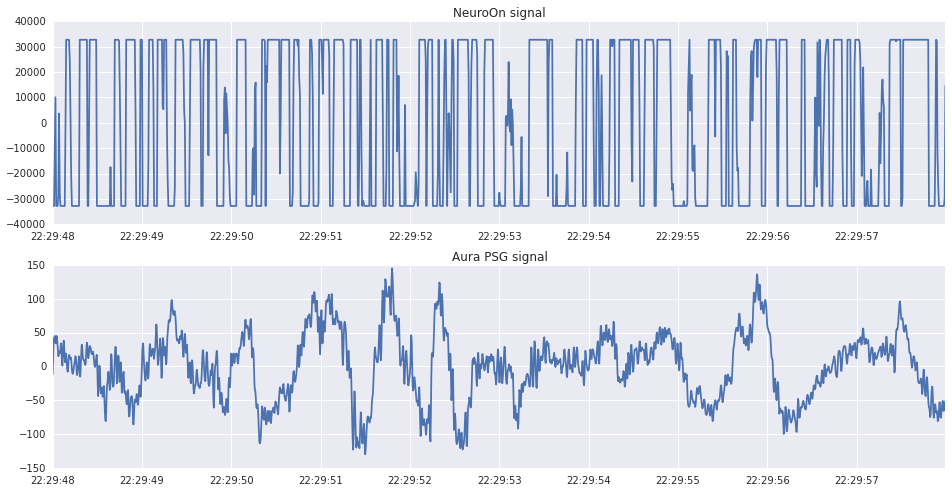

In [65]:
from matplotlib import pyplot as pp
import seaborn as sns
pp.rcParams['figure.figsize'] = (16.0, 8.0)

def plot_signal_fragment(
    csv_sig, edf_sig, edf_start_time,
    csv_rate=125, edf_rate=200, seconds=10, shift=0,
    csv_title='NeuroOn signal',
    edf_title='Aura PSG signal'
):
    csv_shift = shift * csv_rate
    edf_shift = shift * edf_rate
    # First subplot
    pp.subplot(211)
    csv_signal_fragment = csv_sig[
        csv_shift :
        csv_shift + seconds * csv_rate
    ]
    pp.title(csv_title)
    x_csv = csv_signal_fragment[:,0]
    xticks_csv = [
        datetime.fromtimestamp(x/1000).strftime('%H:%M:%S') for x in x_csv[::csv_rate]
    ]
    pp.xticks(x_csv[::csv_rate], xticks_csv)
    y_csv = csv_signal_fragment[:,1]
    pp.plot(x_csv, y_csv)
    # Second subplot
    pp.subplot(212)
    pp.title(edf_title)
    edf_signal_fragment = edf_sig[edf_shift : edf_shift + seconds * edf_rate]
    x_edf = np.linspace(
        (shift + edf_start_time) * 1000,
        (shift + edf_start_time + seconds) * 1000,
        seconds * edf_rate
    )
    xticks_edf = [
        datetime.fromtimestamp(x/1000).strftime('%H:%M:%S') for x in x_edf[::edf_rate]
    ]
    pp.xticks(x_edf[::edf_rate], xticks_edf)
    y_edf = edf_signal_fragment
    pp.plot(x_edf, y_edf)
    return pp.show()

plot_signal_fragment(
    no_shifted_signal, psg_signal, psg_start_timestamp
)


It seems that NeuroOn cannot handle all the muscle artifacts from the very first minutes of the experiment. Let's try to shift it 10 minutes and see if the signal makes sense then.

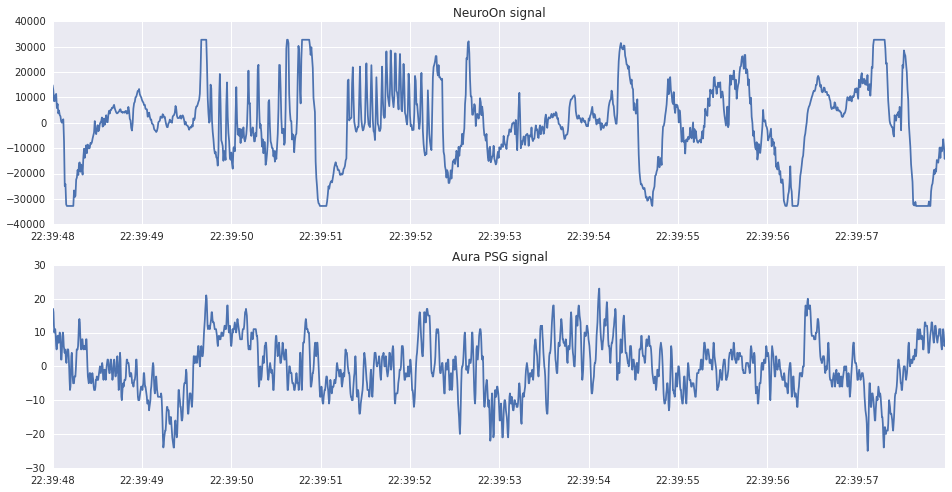

In [67]:
plot_signal_fragment(
    no_shifted_signal, psg_signal, psg_start_timestamp,
    shift=600
)

While much clearer, NeuroOn's signal doesn't look similar to Aura's. We shouldn't trust just naked eye (amplitude/time) comparisons, let's try [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) analysis (frequency/time).

**TODO**:
 - use Pandas
 - make more use of Seaborn
 - FFT visual comparison
 - [windowing](https://en.wikipedia.org/wiki/Window_function)
 - [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
 - correlation in time (maybe the timestamps aren't correct)